In [1]:
from tokenizers.implementations import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer(
    "../../BPEtokenizer/vocab.json",
    "../../BPEtokenizer/merges.txt",
)

In [2]:
tokenizer.enable_truncation(max_length=512)

In [3]:
from transformers import GPT2Config

config = GPT2Config(
    vocab_size=50_000,
    n_positions=514,
    n_head=12,
    n_layer=6,
)

In [4]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("../../BPEtokenizer", max_len=512)
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [5]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel(config=config)

In [6]:
model.config.pad_token_id = model.config.eos_token_id

In [7]:
model.num_parameters()

81323520

DATASET

In [8]:
from datasets import load_dataset
dataset = load_dataset("text", data_files="../../data/unlabeled_data_sentences.txt", split='train') #, split='train', streaming=True)
# dataset = load_dataset("text", data_files=r"..\ttmp\unlabeled_data_sentences.txt", split='train').shuffle()
dataset

Found cached dataset text (C:/Users/Jonathan Ipe/.cache/huggingface/datasets/text/default-380bcce244e545de/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


Dataset({
    features: ['text'],
    num_rows: 28046
})

In [9]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 22436
    })
    test: Dataset({
        features: ['text'],
        num_rows: 5610
    })
})

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/22436 [00:00<?, ? examples/s]

Map:   0%|          | 0/5610 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 22436
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 5610
    })
})

In [12]:
train_dataset = tokenized_datasets['train']
val_dataset = tokenized_datasets['test']

In [13]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

PRETRAINING

In [14]:
import torch

In [15]:
torch.cuda.is_available()

True

In [18]:
import wandb
wandb.init(mode="disabled")

In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="../../models/GPT2-Pretrained",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_steps=10_000,
    evaluation_strategy="steps",
    eval_steps=250,
    # save_total_limit=2,
    # max_steps=100,  # specify the number of steps
    # logging_dir='./logs',  # directory for storing logs
    logging_steps=250,  # log training information every 50 steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # If you have a validation dataset
    # compute_metrics=compute_metrics
)

In [19]:
%%time
train_result = trainer.train()

  0%|          | 0/2805 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 3.9065, 'learning_rate': 4.554367201426025e-05, 'epoch': 0.09}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 3.0493619441986084, 'eval_runtime': 99.0184, 'eval_samples_per_second': 56.656, 'eval_steps_per_second': 7.09, 'epoch': 0.09}
{'loss': 2.9541, 'learning_rate': 4.10873440285205e-05, 'epoch': 0.18}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.8342039585113525, 'eval_runtime': 100.252, 'eval_samples_per_second': 55.959, 'eval_steps_per_second': 7.002, 'epoch': 0.18}
{'loss': 2.7685, 'learning_rate': 3.6631016042780753e-05, 'epoch': 0.27}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.631448268890381, 'eval_runtime': 103.0228, 'eval_samples_per_second': 54.454, 'eval_steps_per_second': 6.814, 'epoch': 0.27}
{'loss': 2.5997, 'learning_rate': 3.2174688057041004e-05, 'epoch': 0.36}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.513180732727051, 'eval_runtime': 109.3242, 'eval_samples_per_second': 51.315, 'eval_steps_per_second': 6.421, 'epoch': 0.36}
{'loss': 2.5182, 'learning_rate': 2.7718360071301247e-05, 'epoch': 0.45}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.440329074859619, 'eval_runtime': 94.2363, 'eval_samples_per_second': 59.531, 'eval_steps_per_second': 7.449, 'epoch': 0.45}
{'loss': 2.4646, 'learning_rate': 2.32620320855615e-05, 'epoch': 0.53}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.388923168182373, 'eval_runtime': 88.0855, 'eval_samples_per_second': 63.688, 'eval_steps_per_second': 7.97, 'epoch': 0.53}
{'loss': 2.4187, 'learning_rate': 1.8805704099821748e-05, 'epoch': 0.62}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.354825019836426, 'eval_runtime': 92.09, 'eval_samples_per_second': 60.919, 'eval_steps_per_second': 7.623, 'epoch': 0.62}
{'loss': 2.3894, 'learning_rate': 1.4349376114081997e-05, 'epoch': 0.71}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.327408790588379, 'eval_runtime': 89.3932, 'eval_samples_per_second': 62.756, 'eval_steps_per_second': 7.853, 'epoch': 0.71}
{'loss': 2.3673, 'learning_rate': 9.893048128342247e-06, 'epoch': 0.8}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.30847430229187, 'eval_runtime': 97.7408, 'eval_samples_per_second': 57.397, 'eval_steps_per_second': 7.182, 'epoch': 0.8}
{'loss': 2.3268, 'learning_rate': 5.436720142602496e-06, 'epoch': 0.89}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.294293165206909, 'eval_runtime': 111.7228, 'eval_samples_per_second': 50.214, 'eval_steps_per_second': 6.283, 'epoch': 0.89}
{'loss': 2.3241, 'learning_rate': 9.80392156862745e-07, 'epoch': 0.98}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.285398483276367, 'eval_runtime': 177.0323, 'eval_samples_per_second': 31.689, 'eval_steps_per_second': 3.965, 'epoch': 0.98}
{'train_runtime': 2352.0174, 'train_samples_per_second': 9.539, 'train_steps_per_second': 1.193, 'train_loss': 2.6335545449758384, 'epoch': 1.0}
CPU times: total: 39min 16s
Wall time: 39min 12s


In [21]:
trainer.save_model("../../models/GPT2-Pretrained")

In [22]:
trainer.state.log_history

[{'loss': 3.9065,
  'learning_rate': 4.554367201426025e-05,
  'epoch': 0.09,
  'step': 250},
 {'eval_loss': 3.0493619441986084,
  'eval_runtime': 99.0184,
  'eval_samples_per_second': 56.656,
  'eval_steps_per_second': 7.09,
  'epoch': 0.09,
  'step': 250},
 {'loss': 2.9541,
  'learning_rate': 4.10873440285205e-05,
  'epoch': 0.18,
  'step': 500},
 {'eval_loss': 2.8342039585113525,
  'eval_runtime': 100.252,
  'eval_samples_per_second': 55.959,
  'eval_steps_per_second': 7.002,
  'epoch': 0.18,
  'step': 500},
 {'loss': 2.7685,
  'learning_rate': 3.6631016042780753e-05,
  'epoch': 0.27,
  'step': 750},
 {'eval_loss': 2.631448268890381,
  'eval_runtime': 103.0228,
  'eval_samples_per_second': 54.454,
  'eval_steps_per_second': 6.814,
  'epoch': 0.27,
  'step': 750},
 {'loss': 2.5997,
  'learning_rate': 3.2174688057041004e-05,
  'epoch': 0.36,
  'step': 1000},
 {'eval_loss': 2.513180732727051,
  'eval_runtime': 109.3242,
  'eval_samples_per_second': 51.315,
  'eval_steps_per_second': 6.4

In [28]:
with open("../../training-logs/", 'w') as f:
    for state in trainer.state.log_history:
        f.write(f"{state}\n")

In [29]:
train_loss_list = []
eval_loss_list = []
epoch_train_list = []
epoch_eval_list = []

for state in trainer.state.log_history:
    if "loss" in state:
        train_loss_list.append(state["loss"])
        epoch_train_list.append(state["epoch"])
    elif "eval_loss" in state:
        eval_loss_list.append(state["eval_loss"])
        epoch_eval_list.append(state["epoch"])

In [30]:
import matplotlib.pyplot as plt
import numpy as np

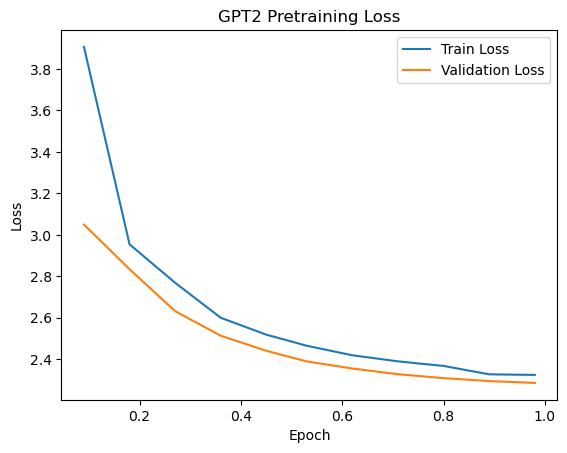

In [31]:
plt.plot(epoch_train_list, train_loss_list)
plt.plot(epoch_eval_list, eval_loss_list)
plt.legend(['Train Loss', 'Validation Loss'])
plt.title("GPT2 Pretraining Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()